# Imports and settings

In [136]:
import adaptive_latents as al
from adaptive_latents import mmICA, sjPCA, proSVD, CenteringTransformer, Pipeline, NumpyTimedDataSource
import matplotlib.pyplot as plt
import numpy as np
from datasets import Leventhal24uDataset
from picard import permute
import sklearn
import matlab.engine

rng = np.random.default_rng(0)


In [137]:
plt.rc('lines', linewidth=2)
plt.rc('font', family='sans')


# Simulated data

In [138]:
dt = 0.03 # seconds
log_y = True
colors = ["#F94B00", "#2FA194", "#EC3C8E"]
common_ylim = [.008, 4] 

## sjPCA

In [139]:
X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=500, n=6, stddev=1)

In [140]:
eng = matlab.engine.start_matlab()

params = dict(
meanSubtract=False,
normalize=False,
suppressBWrosettes=True,
suppressHistograms=True,
suppressText=True,
)

proj, summary = eng.jPCA({'A':X}, [], params, nargout=2)

offline_U = np.array(summary['jPCs_highD'])


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable


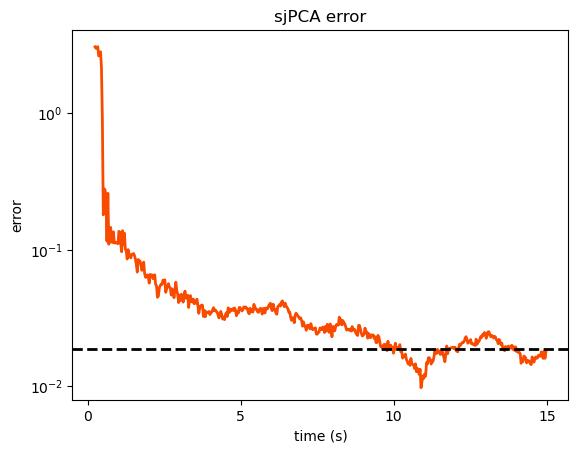

In [141]:
jp = sjPCA(log_level=1)
jp.offline_run_on(NumpyTimedDataSource(X, timepoints = np.arange(X.shape[0]) * dt))

distances, t = jp.get_distance_from_subspace_over_time(true_variables['C'])



fig, ax = plt.subplots()
ax.plot(t, distances[:,0], color=colors[0])
ax.set_xlabel('time (s)')
ax.set_ylabel('error') # the error is the sum of (the absolute values of) the principal angles between the correct and discovered subspaces
# ax.axhline(2 * np.pi/2, color='k', linestyle = '--')
ax.set_xticks([0,5,10,15])


offline_error = al.utils.principle_angles(offline_U[:,:2], true_variables['C']).sum()

if log_y:
    ax.semilogy()
    ax.set_yticks([1, .1, .01])
    ax.minorticks_off()
else:
    ax.set_yticks([0,1,2,3])
ax.set_title("sjPCA error")
ax.set_ylim(common_ylim)
ax.axhline(y=offline_error, linestyle='--', color='k')



## mmICA

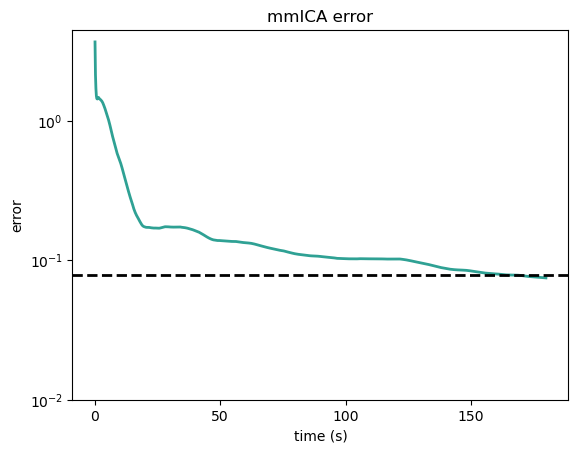

In [142]:

ica = mmICA(alpha=.5, maxiter_cg=20, tol=1e-20, log_level=1)
m = 1_000 # number of blocks
n = 6 # size of each block

# X = rng.normal(size=(m, n, n)); X[::2,:,:] += 10; X[1::2,:,:] -= 10;
X = rng.laplace(size=(m, n, n))

input_data = NumpyTimedDataSource(X, timepoints = np.arange(m) * n * dt )

ica.offline_run_on(input_data)


ts = []
errors = []
for W, t in zip(ica.log['W'], ica.log['t']):
    ts.append(t)
    error = permute(W) - np.eye(W.shape[0])
    errors.append(np.linalg.norm(error))
ts = np.squeeze(ts)
errors = np.squeeze(errors)

fig, ax = plt.subplots()
ax.plot(ts, errors, color=colors[1])
ax.set_xlabel('time (s)')
ax.set_ylabel('error')
ax.set_xticks([0,50,100,150])

W = sklearn.decomposition.FastICA(max_iter=5000).fit(X.transpose([0,2,1]).reshape(-1,n)).components_
offline_error = np.linalg.norm(permute(W) - np.eye(W.shape[0]))

if log_y:
    ax.semilogy()
    ax.set_yticks([1, .1, .01])
    ax.minorticks_off()
else:
    ax.set_yticks([0,1,2])

ax.set_title("mmICA error")
# ax.set_ylim(common_ylim)
ax.axhline(offline_error, color='k', linestyle = '--')



## proSVD

Text(0, 0.5, 'error')

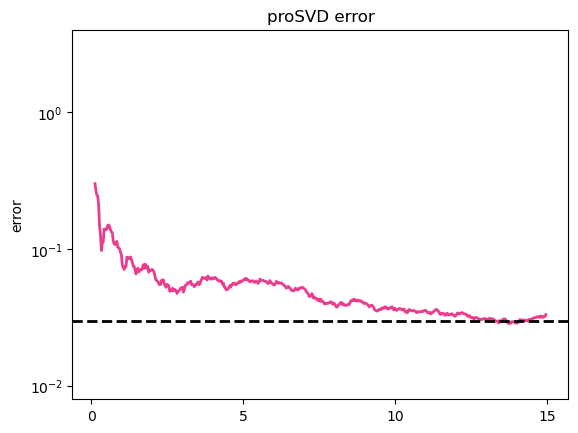

In [143]:
X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=500, n=8, stddev=1)
pro = proSVD(k=4, log_level=1)

pro.offline_run_on(NumpyTimedDataSource(X, timepoints=np.arange(X.shape[0]) * dt))

fig, ax = plt.subplots()

Q_error, t = pro.get_distance_from_subspace_over_time(true_variables['C'])



ax.plot(t, Q_error, color=colors[2])
ax.set_xticks([0,5,10,15])

_, s, Vt = np.linalg.svd(X)
V = Vt[np.argsort(s)[::-1], :].T[:,:pro.k]
offline_error = al.utils.principle_angles(V,true_variables['C']).sum()
ax.axhline(offline_error, color='k', linestyle = '--')


if log_y:
    ax.semilogy()
    ax.set_yticks([1, .1, .01])
    ax.minorticks_off()
else:
    ax.set_yticks([0,.5])

ax.set_title("proSVD error")
ax.set_ylim(common_ylim)
ax.set_ylabel('error')




# Real data

In [144]:
raise Exception()

Exception: 

In [ ]:
%%capture 
d = Leventhal24uDataset(); # the official function I found to load some of the files annoyingly has print statements

In [ ]:
jp = sjPCA(log_level=1)

pipeline = Pipeline([
    CenteringTransformer(),
    proSVD(k=6),
    jp
])

pipeline.offline_run_on(d.neural_data)

distances, t = jp.get_distance_from_subspace_over_time(jp.log['U'][3000][:,0:2])
plt.plot(t, distances)
# plt.semilogy()


In [ ]:
d.neural_data.t[-1]